In [1]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch import FloatTensor
from torch import cuda
import matplotlib.pylab as plt
import time
import math
import random
import pickle
from tqdm import tqdm_notebook as tqdm
random.seed(100)

In [2]:
class Sigmoid:
    def forward(self, x):
        self.sigm = torch.sigmoid(x)
        return self.sigm
        
    def backward(self, dz, lr = 0.001):
        return dz * torch.mul((1 - self.sigm),self.sigm)

In [3]:
class Dense:
    def __init__(self, in_size, out_size):
        self.W = torch.randn(out_size, in_size)
        self.b = torch.randn(out_size)
    
    def forward(self, x):
        self.x = x
        return torch.mv(self.W, x) + self.b
    
    def backward(self, dz, lr = 0.001):
        local_derivative = self.W
        
        db = dz * lr
        self.b = self.b - db
        
        dW = torch.ger(dz, self.x) * lr
        self.W = self.W - dW
        return torch.mv(local_derivative.t(), dz)
    
    def cuda(self):
        self.W.cuda()
        self.b.cuda()
        

In [4]:
class Softmax:
    def forward(self, x):
        exps = torch.exp(x)
        self.softmax = exps / torch.sum(exps) 
        return self.softmax
    
    def backward(self, dz, lr = 0.001):
        local_derivative = torch.diag(self.softmax) - torch.ger(self.softmax, self.softmax)
        return torch.mv(local_derivative, dz)


In [5]:
class ReLu:
    
    def forward(self, x):
        self.x = x
        return torch.max(torch.zeros(x.size()[0]), x)
    
    def backward(self, dz, lr=0.1):
        dz[self.x < 0] = 0
        return dz

In [6]:
class CrossEntropy:
    
    def forward(self, y_true, y_hat):
        self.y_true = y_true
        self.y_hat = y_hat
        return -torch.sum(y_true * np.log(y_hat))
    
    def backward(self, dz, lr=0.001):
        return dz * -1. * self.y_true / self.y_hat

In [7]:
class MSQE:
    
    def forward(self, y_true, y_hat):
        self.y_true = y_true
        self.y_hat = y_hat
        return torch.sum(torch.pow(y_true - y_hat, 2))
    
    def backward(self, dz, lr=0.001):
        return - 2 * (self.y_true - self.y_hat)

In [58]:
class Net:
    
    def __init__(self):
        self.layers = []
        self.layers.append(Dense(784, 10))
        self.layers.append(Sigmoid())
        self.layers.append(Dense(10, 10))
        self.layers.append(Softmax())
        
    def forward(self, x):
        net = x
        for i in range(len(self.layers)):
            net = self.layers[i].forward(net)
        return net
    
    def backward(self, dz, lr):
        
        for i in range(len(self.layers)):
            dz = self.layers[-(i + 1)].backward(dz, lr)
        return dz
    
    def cuda(self):
        for layer in self.layers:
            if type(layer) == Dense:
                layer.cuda()

# Загружаем датасет и приводим его в удобный вид

In [59]:
from sklearn.datasets import fetch_openml
data, target = fetch_openml('mnist_784', version=1, return_X_y=True)

In [60]:
data = data/255

In [61]:
X = []
for i in tqdm(range(int(data.shape[0]))):
    X.append(torch.FloatTensor(data[i].astype(float)))

Y = []
eye = torch.eye(10)
for i in range(data.shape[0]):
    Y.append(eye[int(target[i])])
    
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, stratify=target, shuffle=True)

# Немного функций для дебага

In [62]:
def max_index(vec):
    size = len(vec)

    max_value = -1
    max_index = -1
    for i in range(size):
        if list(vec)[i] > max_value:
            max_value = vec[i]
            max_index = i

    return max_index

def prediction_accuracy(net, test_data=X_test, test_target=Y_test, count = -1):
    if count < 0:
        count = len(test_data)
        
    acc = 0
    for i in range(count):
        if max_index(net.forward(test_data[i])) == max_index(test_target[i]):
            acc+=1
        
    return acc / count
    

# Обучаем сеть на CPU

In [63]:
def train(net, loss, lr, epoch_size, noise_scale=0.1):
    L_iter = []
        
    L_acc = 0
    iter_in_epoch = 0
    lr_dec = 0.095 * epoch_size / len(X_train)
    for i in tqdm(range(len(X_train))):
        y_h = net.forward(X_train[i] + (torch.FloatTensor(784).random_(0,100)*0.01 * noise_scale))
        L_acc += loss.forward(Y_train[i], y_h)
        dz = loss.backward(1, lr)
        net.backward(dz, lr)
        iter_in_epoch += 1
        if iter_in_epoch == epoch_size:
            lr -= lr_dec
            L_iter.append(L_acc)
            iter_in_epoch = 0
            L_acc = 0
        
    return(L_iter)
    
net = Net()
loss = CrossEntropy()
print('точность до обучения', prediction_accuracy(net))
noise_scale = 0.0
L_iter = train(net, loss, 0.1, 1000, noise_scale)
print('точность после обучения', prediction_accuracy(net))

точность до обучения 0.10928571428571429



точность после обучения 0.8782857142857143


Text(0,0.5,'Cross Entropy Loss')

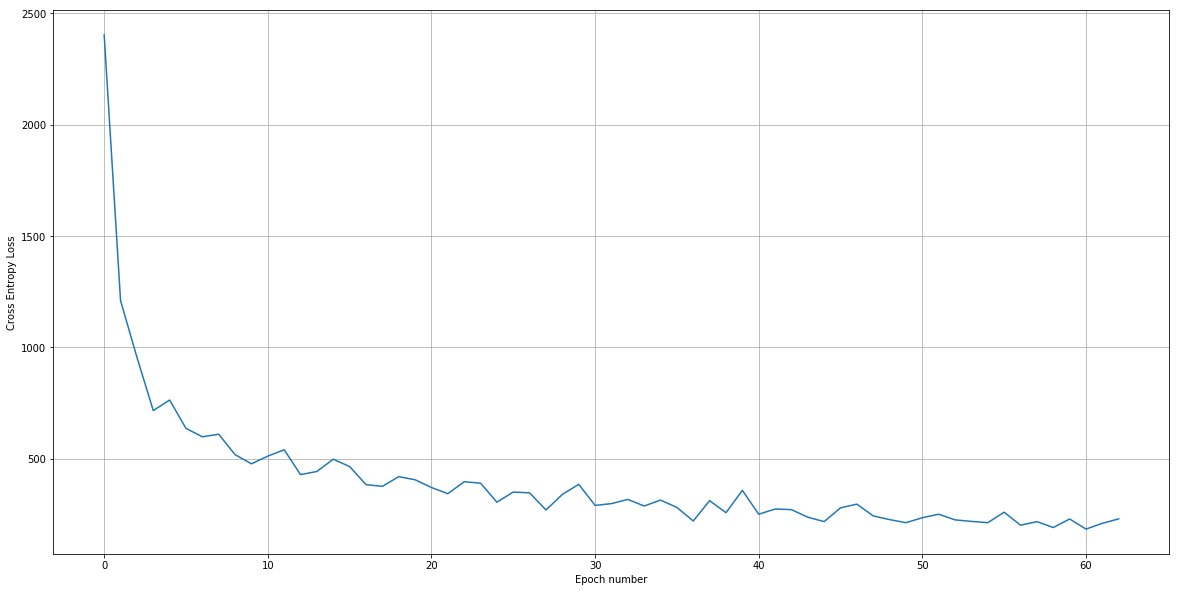

In [57]:
fig = plt.figure(figsize=(20,10))

ax = fig.gca()
#ax.set_xticks(np.arange(0, 600, 100))
#ax.set_yticks(np.arange(0, 600, ))
plt.plot(L_iter)
plt.grid()

plt.xlabel("Epoch number")
plt.ylabel("Cross Entropy Loss")

#plt.savefig("Cross_Entropy_Loss.png")

# Наблюдаем результат работы

предсказание 1
вероятность предсказания 0.9888917207717896
на самом деле 1


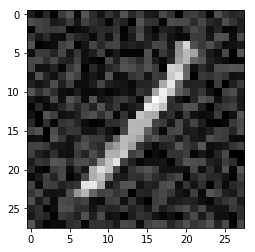

In [55]:
r = random.randint(0, len(X_test))

print('предсказание',max_index(net.forward(X_test[r])))
print('вероятность предсказания', torch.sum(net.forward(X_test[r]) * Y_test[r]))
print('на самом деле', max_index(Y_test[r]))
I = (X_test[r] + (torch.FloatTensor(784).random_(0,100)*0.01 * noise_scale)).numpy()
I = I.reshape((28, 28))
plt.imshow(I, cmap='gray');